In [1]:
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
import os
from tqdm import tqdm_notebook as tqdm

from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.utils import plot_some, plot_history
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data
from nets import unet

Using TensorFlow backend.
/home/npmartins/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/npmartins/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/npmartins/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
limit_gpu_memory(fraction=1/2)

In [3]:
base_dir = '/paht/to/image/dir'
train_dir = os.path.join(base_dir, 'trainImages')
label_dir = os.path.join(base_dir, 'trainLabels')

In [4]:
imgList = os.listdir(train_dir)
labelList = os.listdir(label_dir)

imgArray = []
for image in tqdm(imgList, 'Reading img'):
    imgArray.append(imread(os.path.join(train_dir, image)))

labelArray = []
for label in tqdm(labelList, 'Reading label'):
    labelArray.append(imread(os.path.join(label_dir, label)))

/home/npmartins/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/home/npmartins/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [5]:
print(imgArray[0].shape)
print(labelArray[0].shape)

(752, 752)
(752, 752)


In [6]:
raw_data = RawData.from_arrays(
    imgArray,
    labelArray,
    axes='YX'
)

In [10]:
X, Y, XY_axes = create_patches(
    raw_data=raw_data,
    patch_size=(128, 128, 1),
    patch_axes='YXC',
    n_patches_per_image=25,
    save_file='/mydata.npz'
)

  459 raw images x    1 transformations   =   459 images
  459 images     x   25 patches per image = 11475 patches in total
Input data:
numpy array
Transformations:
1 x Permute axes to YXC
Patch size:
128 x 128 x 1


100%|██████████| 459/459 [00:10<00:00, 44.30it/s]


Saving data to /mnt/AE3205C73205958D/Data/3dliver_local/pc_adult/2d_slices/imagesXY/images_full/mydata_128x128_2.npz.


In [3]:
(X, Y), (X_val, Y_val), axes = load_training_data(
    '/mydata.npz',
    validation_split=0.1,
    verbose=True
)

number of training images:	 10327
number of validation images:	 1148
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


(10327, 128, 128, 1)
(128, 128, 1)


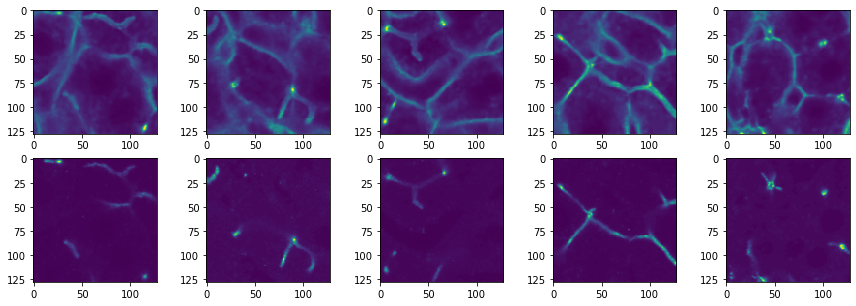

In [4]:
print(X.shape)
n = 10
print(X[n].shape)
fig = plt.figure(figsize=(15,5))
pl1_x = fig.add_subplot(2, 5, 1)
pl1_x.imshow(X[n][...,0])
pl1_y = fig.add_subplot(2, 5, 6)
pl1_y.imshow(Y[n][...,0])
pl2_x = fig.add_subplot(2, 5, 2)
pl2_x.imshow(X[n+1][...,0])
pl2_y = fig.add_subplot(2, 5, 7)
pl2_y.imshow(Y[n+1][...,0])
pl3_x = fig.add_subplot(2, 5, 3)
pl3_x.imshow(X[n+2][...,0])
pl3_y = fig.add_subplot(2, 5, 8)
pl3_y.imshow(Y[n+2][...,0])
pl4_x = fig.add_subplot(2, 5, 4)
pl4_x.imshow(X[n+3][...,0])
pl4_y = fig.add_subplot(2, 5, 9)
pl4_y.imshow(Y[n+3][...,0])
pl5_x = fig.add_subplot(2, 5, 5)
pl5_x.imshow(X[n+4][...,0])
pl5_y = fig.add_subplot(2, 5, 10)
pl5_y.imshow(Y[n+4][...,0])

In [5]:
adam = Adam(lr=1e-4)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model = unet(input_shape=(128, 128, 1), conv_kernel_size=3, dropout=0.5, filters=64, last_activation='sigmoid')
model.compile(optimizer=adam, loss='binary_crossentropy')
#model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
history = model.fit(
    X,
    Y,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, Y_val),
    shuffle=True,
    validation_freq=1
)

Instructions for updating:
Use tf.cast instead.
Train on 10327 samples, validate on 1148 samples
Epoch 1/5
10327/10327 [==============================] - 160s 15ms/step - loss: 0.2675 - val_loss: 0.2464
Epoch 2/5
10327/10327 [==============================] - 152s 15ms/step - loss: 0.2455 - val_loss: 0.2395
Epoch 3/5
10327/10327 [==============================] - 153s 15ms/step - loss: 0.2427 - val_loss: 0.2384
Epoch 4/5
10327/10327 [==============================] - 153s 15ms/step - loss: 0.2402 - val_loss: 0.2355
Epoch 5/5
10327/10327 [==============================] - 153s 15ms/step - loss: 0.2344 - val_loss: 0.2317


['loss', 'val_loss']


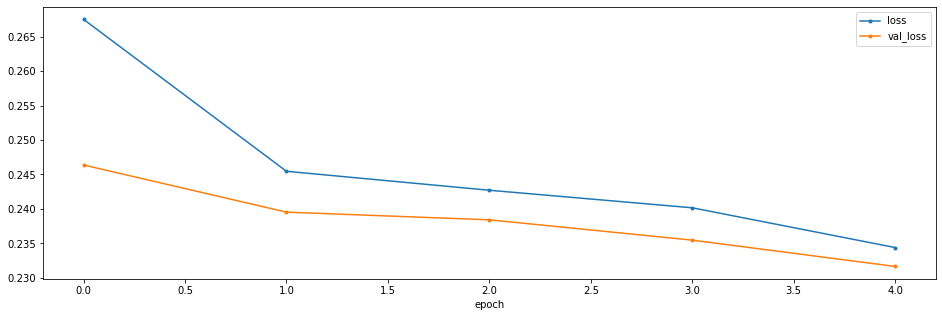

In [8]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history, ['loss', 'val_loss'])

In [9]:
model.save('myunet.h5')